# Neural Search

Nachdem ich ein bisschen erkundet habe, denke ich, dass ich ungefähr weiß, was ich für diese Programme beachten muss. Deshalb werden die nächsten beiden Aufgaben folgende sein:
1. NN implementieren (torch) und in vorherigem environment testen
2. Code präsentierbar machen

## NN Implementieren
Wir versuchen das Ganze in zwei Schritten anzugehen. Zunächst möchte ich ein sehr simples Model ausprobieren:
1.  Programmiere ein einfaches neuronales Netz.
    - Die Inputneuronen sind Ringförmig um den Agenten angeordnet. Jedes Neuron erhält einen Input von 1 (oder abhängig von Einnahme des Beobachtungsfeldes), wenn mindestens ein Ziel in der Winkelregion des Neurons ist.
    - Mit einem einfachen Feedforward Layer und Aktivierungen wie in dem vorherigen Versuch wird die Aktivierung des Netzwerkes ausgerechnet

2. Nachdem sich herausgestellt hat, dass das Ganze doch nicht so simpel ist, ist es erstmal Zeit die Ergebnisse zusammenzufassen:
    - Wir definieren eine Klasse `NeuralAgent`, welche die Bewegung eines Agenten steuert.
    Der Agent wird an einer Position $x=0 \in \mathbb{C}$ initialisiert. Er führt `n_steps` Schritte durch, welche durch die Funktion `step()` beschrieben werden. 
    Schritte werden wie folgt bestimmt: 
        - Der Agent besitzt $n_N$ (`n_neurons`) Neuronen, welche jeweils eine bestimmte Richtung kodieren. Jedes Neuron hat eine Aktivierung $\in [0, 1]$, welche die Präferenz des Agenten in die korrespondierende Richtung angibt. Die Aktivierung setzt sich aus einer `base_activation` und den Interaktion zwischen Neuronen zusammen.
        Die Interaktion zwischen Neuronen ist durch $W_{ij}= \cos\left(\pi \left(\frac{|\theta_{ij}|}{\pi}\right)^{\nu}\right)$ gegeben. Die Anzahl der Targets sei durch $n_T$ gegeben.
        - Die Aktivierungen werden mit $(a_0)_i = 1$ initialisiert. Ein Schritt `step()` besteht dann daraus zunächst die `base_activation` zu berechnen, dann die Interaktionen ein- oder mehrmals zu berechnen (bis zum Equilibrium, aber das ist nicht unbedingt nötig) und zuletzt die Position des Agenten in die durchschnittliche Richtung der Neuronen zu bewegen.
        - Die `base_activation` für ein Neuron wird durch $(b_{n+1})_i = (a_n)_i \max_{j=1,...,n_T} n_\sigma(|\theta_{ij}|), i=1,...,n_N$. Dabei ist $n_\sigma$ die pdf einer Normalverteilten Zufallsvariable mit std $\sigma$ (`activation_width` im Programm) und skaliert, sodass $\max n_\sigma = 1$. Dadurch werden Neuronen, die in sehr andere Richtungen als die Targets zeigen quasi ausgeschaltet.
        Dann werden die Interaktionen durch $a_{n+1} = a_n + \text{ReLU}(\frac{Wb_{n+1}}{||Wb_{n+1}||})$ berechnet.
        


Nach basic Hopfield, vlt das hier implementieren? https://arxiv.org/abs/2008.02217



Ideen:
Was ist, wenn sich das Ziel plötzlich als nicht essbar entpuppt oder als Feind? Vor allem interessant bei ring attractor search.
Verschiedene Stadien: warten, suchen, essen und Übergänge dazwischen. Wiederkehrende Nahrung
    

[1]: Sridhar_al_PNAS_2021


In [55]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
from typing import NamedTuple

# parameter classes
class Param_Agent(NamedTuple):
    start_pos: torch.Tensor
    start_orientation: float
    vel: float

    n_neurons: int
    angle_modifier: float # nu, the neural tuning parameter from before
    activation_width: float # how far away neurons still get an activation from a target
    target_error: float # error of the target angle for each neuron

    sig_scale: float = 1
    target_scale: float = 1
    
class Param_Instance(NamedTuple):
    param_agent: Param_Agent
    n_steps: int
    n_agents: int
    equi_time: int 

    update_mode: int = 1

class Parameter(NamedTuple):
    param_inst: Param_Instance
    n_inst: int
    n_targets: int

    target_init_method: str
    target_init_dist: float = 1
    target_init_scaler: float = np.pi/4
    
    save_dir: str = "/home/feige/Documents/ecosimulation/data/sim_saves/RENAME"

class Generation():
    '''run multiple instances with a given set of parameters and keep track of results'''
    def __init__(self, params:Parameter) -> None:
        self.params = params
        self.n_inst = params.n_inst

        self.targets = Generation.init_targets(n_targets=self.params.n_targets, init_method=self.params.target_init_method, params=self.params)
        self.instances = [Instance(params.param_inst, targets=self.targets) for i in range(self.n_inst)]

    def sim_gen(self):
        for i, inst in enumerate(self.instances):
            inst.run()
            
    def display_runs(self, save_results = False):
        '''Test the current simulation parameters for 100 results, save results, plot results'''

        # plot heatmap
        self.show_generation_trajectories()

        # plot sample trajectory

        # print description

        # save results

    def show_generation_trajectories(self, title="trajectories"):
        ''' display a 2d histogram of the positions of the walkers'''

        # 2d histogram

        lims = self.params.target_init_dist + 1
        range_hist = [[-lims, lims], [-lims, lims]]
        # TODO only works for one agent atm. Fix the [0] in next line 
        traj = torch.concatenate([inst.agent_history[0] for inst in self.instances]).numpy()
        h, xedges, yedges = np.histogram2d(traj.real, traj.imag, bins=100, range=range_hist)
        cmap = plt.colormaps["plasma"]
        cmap.with_extremes(bad=cmap(0))
        pcm = plt.pcolormesh(xedges, yedges, h.T, cmap=cmap, rasterized=True)
        plt.colorbar(pcm, label="# visits", pad=0)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(title)

        # scatter targets on top
        plt.scatter(self.targets.real, self.targets.imag)
        plt.show()

    @staticmethod
    def init_targets(n_targets, init_method, params):
        ''' targets are represented as complex numbers '''
        targets = np.zeros(n_targets, dtype="complex")
        match init_method:
            case "unit_circle":
                # place targets equidistributed on a circle of radius 1
                angles = np.linspace(0, 2*np.pi, n_targets+1)
                targets = params.target_init_dist *np.exp(1.j*angles[:-1])
            case "half_unit_circle":
                # place targets equidistributed on a half-circle of radius 1
                angles = np.linspace(0, np.pi, n_targets)
                targets = params.target_init_dist*np.exp(1.j*angles)
            case "random_circle":
                # place them randomly on a circle of radius 1
                angles = 2*np.pi*np.random.uniform(size=n_targets)
                targets = params.target_init_dist*np.exp(1.j*angles)
            case "full_env":
                # init them by drawing from a 2D normal distribution 
                targets_real = np.random.normal(loc=0, scale=params.target_init_scaler, size=(n_targets,2))
                targets = targets_real[...,0] +1j * targets_real[...,1]
            case "set_degrees":
                # place targets a set degree apart
                targets = params.target_init_dist*np.exp(1j*params.target_init_scaler*np.arange(n_targets))   
                
        targets = torch.tensor(targets)
        return targets 

class Instance():
    ''' control one instance of the simulation. Eventually use gpus to speed this up'''
    device = torch.device("cpu")

    def __init__(self, params: Param_Instance, targets) -> None:
        self.params = params
        self.all_targets: torch.Tensor = targets

        self.agents: list[Agent] = [NeuralAgent(params.param_agent) for i in range(params.n_agents)]
        for agent in self.agents:
            agent.set_targets(self.all_targets)
            
        self.agent_history = torch.zeros(self.params.n_agents, self.params.n_steps, dtype=torch.complex128)

    def run(self):
        for i in range(self.params.n_steps):
            for j, agent in enumerate(self.agents):
                self.agent_history[j,i], _ = agent.step(self.params.equi_time, mode=self.params.update_mode)


class Agent():
    def __init__(self, params: Param_Agent) -> None:
        self.params = params

    def step(self):
        pass

class NeuralAgent(Agent):
    def __init__(self, params: Param_Agent) -> None:
        super().__init__(params)
        self.params = params
        self.angles, self.activations = self.init_neurons()

        self.weight_matrix = self.init_weights()

        self.pos = self.params.start_pos
        self.vel = self.params.vel

    def __str__(self):
        # describe neural net
        return "Update me!"

    def init_weights(self):
        ''' init the weight matrix based on pairwise angles'''
        pdiff = torch.absolute(self.angles.unsqueeze(1) - self.angles) # pairwise distances between angles
        min_angle = torch.minimum(pdiff, 2*torch.pi - pdiff) 
        J_ij = torch.cos(torch.pi*(min_angle/torch.pi)**self.params.angle_modifier) # weight matrix

        return J_ij
    
    def init_neurons(self):
        '''create neurons and set base activation to 1'''
        angles = torch.linspace(-np.pi, np.pi, self.params.n_neurons+1, dtype=torch.double)
        activations = torch.ones(self.params.n_neurons, dtype=torch.double)

        # create an activation function for the neurons. This activates neurons based on the angle between the neuron and the targets
        normal_std = self.params.activation_width
        activation_func = lambda theta: 1/(normal_std*np.sqrt(2*np.pi))*torch.exp(-1/2*(theta/normal_std)**2)
        max_base_activation = torch.max(activation_func(torch.tensor(np.linspace(0, 2*np.pi)))) # normalization
        self.target_activation_func = lambda theta: activation_func(theta)/max_base_activation
        return angles[:-1], activations
    
    def set_targets(self, targets):
        self.targets = targets

    def step(self, equi_time = 100, mode=1, ax=None):
        '''perform one step'''
        match mode:
            case 1:
                # first, activate neurons
                self.activations = torch.mul(self.activations,self.activate_neurons())
                if ax is not None:
                    ax = self.visualize_net(mode="curr_state", ax=ax)
                # then update the neuron weights (until equilibrium)
                self.activations = self.update_neurons_1(equi_time)

                    
            case 2:
                # then update the neuron weights (until equilibrium)
                self.activations = self.update_neurons_2(equi_time)  

        if ax is not None:
            ax = self.visualize_net(mode="curr_state", ax=ax)
            
        # move in average direction of neuron activation
        self.update_position()
        return self.pos, ax
    
    def activate_neurons(self):
        # find the activation the neurons get from the target and multiply by our current activation.
        # Basically, this only allows certain directions to be activated

        pdiff = torch.absolute((self.angles).unsqueeze(1) - torch.angle(self.targets)) # pairwise distances between angles
        min_angles = torch.minimum(pdiff, 2*torch.pi - pdiff)*torch.exp(self.params.target_error*torch.randn(self.params.n_neurons,self.targets.shape[0])) 
        target_activations = torch.max(self.target_activation_func(min_angles), dim=1).values
        return target_activations

    def update_neurons_1(self, times = 1):
        ''' '''
        
        for i in range(times):

            # This is the first activation function I implemented
            # multiply weight matrix with current activation tensor
            new_vec = torch.matmul(self.weight_matrix,self.activations)
            # scale this down
            scaled_vec =self.activations +new_vec/torch.sum(torch.abs(new_vec))

            relu = torch.nn.ReLU()
            self.activations = torch.min(torch.tensor([1]), relu(scaled_vec))

        return self.activations

    def update_neurons_2(self, times = 1):
        for i in range(times):
            target_activ = self.params.target_scale*self.activate_neurons()
            inter_activ = torch.matmul(self.weight_matrix,self.activations)
            self.activations = torch.sigmoid(self.params.sig_scale*(target_activ + inter_activ))
        return self.activations

    def update_position(self):
        angle = torch.angle(torch.sum(self.activations*torch.exp(1j*self.angles)))
        dir = torch.exp(1j*angle)
        self.pos = self.pos + self.vel*dir
        self.targets = self.targets - self.vel*dir
        
    def visualize_net(self, i=None, mode = "def", ax=None):
        '''draw the neural network as well as targets and indicate the neuron activations with colour'''
        if ax is None:
            ax = plt.subplot()

        if mode == "def" or mode =="def+":
            cmap = colormaps["viridis"]
            neuron_pos = torch.exp(1j*self.angles)
            if i is not None:
                # draw lines from the chosen neuron with colours indicating their interactions
                cmap = colormaps["viridis"]
                for j in range(self.params.n_neurons):
                    if i is not j:
                        # draw a line from neuron i to neuron j and show different color based on weight_matrix
                        color_val = 1/2*(1+self.weight_matrix[i,j])
                        ax.plot([neuron_pos[i].real, neuron_pos[j].real], [neuron_pos[i].imag, neuron_pos[j].imag],color=cmap(color_val))

            else:
                # draw all lines
                for i in range(self.params.n_neurons):
                    for j in range(self.params.n_neurons):
                        if i is not j:
                            # draw a line from neuron i to neuron j and show different color based on weight_matrix
                            color_val = 1/2*(1+self.weight_matrix[i,j])
                            ax.plot([neuron_pos[i].real, neuron_pos[j].real], [neuron_pos[i].imag, neuron_pos[j].imag],color=cmap(color_val),lw=0.1)
        
        if mode == "def+" or mode=="target_activation":
            angles = torch.zeros(len(self.neurons))
            radii = torch.zeros(len(self.neurons))
            for i, neuron in enumerate(self.neurons):
                angles[i] = neuron.pref_angle
                radii[i] = 1 + 1/3*neuron.activate(self.targets)

            points = radii*torch.exp(1j*angles)
            points = torch.cat((points, points[0].reshape(1)))
            
            plt.plot(points.real, points.imag, )
            plt.scatter(torch.exp(1j*angles).real, torch.exp(1j*angles).imag)
            plt.scatter(2*self.targets.real, 2*self.targets.imag)
            
            lim = 3
            plt.xlim([-lim,lim])
            plt.ylim([-lim,lim])
            
        if mode == "curr_state":
            radii = 1 + 1/3*self.activations
            print(radii.shape)
            points = radii*torch.exp(1j*self.angles)
            points = torch.cat((points, points[0].reshape(1)))
            
            ax.plot(points.real, points.imag, )
            #plt.scatter(torch.exp(1j*self.angles).real, torch.exp(1j*self.angles).imag)
            ax.scatter(self.targets.real, self.targets.imag)
            ax.scatter([0], [0])

            lim = 5
            plt.xlim([-lim,lim])
            plt.ylim([-lim,lim])

        return ax
      


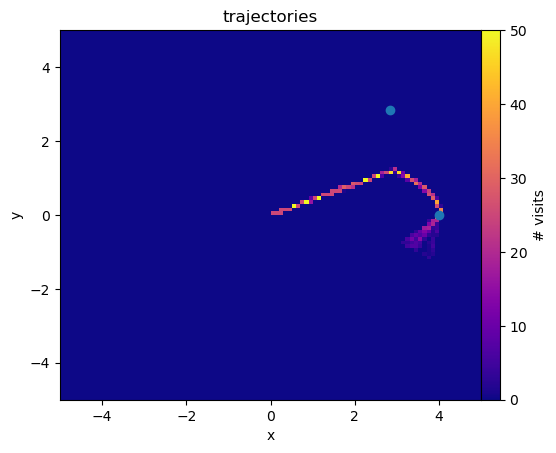

In [500]:
### CELL FOR MULTIPLE INSTANCES ### 
p_agent = Param_Agent(start_pos=torch.tensor(0+0j), start_orientation=0, vel=0.08, n_neurons=60, 
                      angle_modifier=0.5, activation_width=0.2, target_error=0.1, sig_scale=5, target_scale=10)
p_inst = Param_Instance(param_agent=p_agent, n_steps=75, n_agents=1, equi_time=100, update_mode=2)
p_gen = Parameter(param_inst=p_inst, n_inst=25, n_targets=2, target_init_method="set_degrees", target_init_dist = 4)
gen = Generation(params=p_gen)
gen.sim_gen()
gen.show_generation_trajectories()

torch.Size([60])


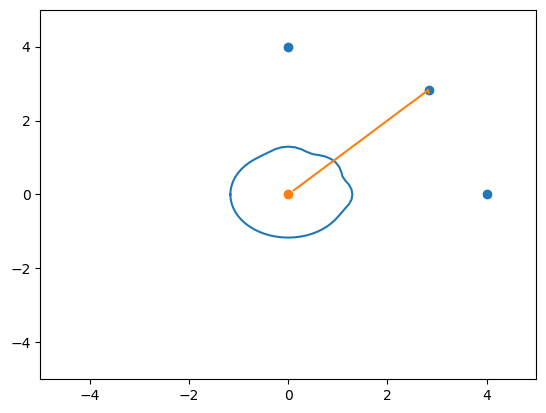

In [57]:
### CELL FOR TESTING ONE INSTANCE ###
p_agent = Param_Agent(start_pos=torch.tensor(0+0j), start_orientation=0, vel=0.08, n_neurons=60, 
                      angle_modifier=0.5, activation_width=0.2, target_error=0.02, sig_scale=1, target_scale=2)
p_inst = Param_Instance(param_agent=p_agent, n_steps=50, n_agents=1, equi_time=10, update_mode=2)
p_gen = Parameter(param_inst=p_inst, n_inst=50, n_targets=3, target_init_method="set_degrees", target_init_dist = 4)
gen = Generation(params=p_gen)
inst = gen.instances[0]
# targets = 4*torch.exp(1j*torch.tensor([-np.pi*1/5, np.pi*1/5]))
# inst.agents[0].targets = targets

# show how the targets activate the network and then 
ax = plt.subplot()
ax = inst.agents[0].step(equi_time=p_inst.equi_time, mode=p_inst.update_mode, ax=ax)

inst.run()
hist = inst.agent_history[0]
plt.plot(hist.real, hist.imag)

In [474]:
### CELL FOR TESTING ONE RUN ### 
p_agent = Param_Agent(start_pos=torch.tensor(0+0j), start_orientation=0, vel=0.15, n_neurons=60, 
                      angle_modifier=0.5, activation_width=0.2, target_error=0.02, sig_scale=5, target_scale=10)
p_inst = Param_Instance(param_agent=p_agent, n_steps=75, n_agents=1, equi_time=100, update_mode=2)
p_gen = Parameter(param_inst=p_inst, n_inst=50, n_targets=2, target_init_method="set_degrees", target_init_dist = 4)
gen = Generation(params=p_gen)
inst = gen.instances[0]
agent = inst.agents[0]


torch.Size([60])


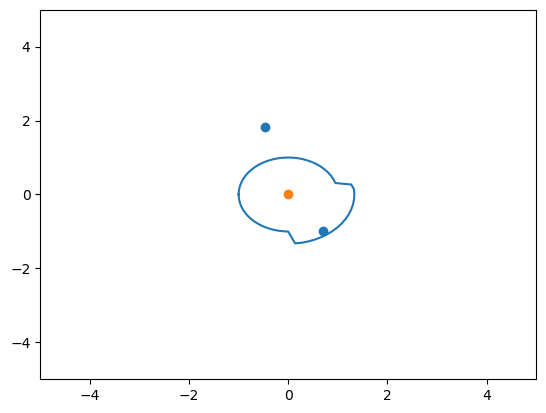

In [499]:
ax = plt.subplot()
ax = agent.step(equi_time=p_inst.equi_time, mode=p_inst.update_mode, ax=ax)


torch.Size([60])


Text(0.5, 1.0, 'neuron activation based on target direction')

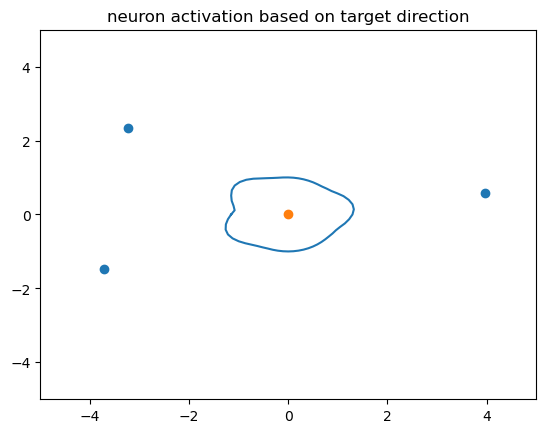

In [729]:
inst = Instance(p_inst)
inst.agents[0].activate_neurons()
inst.agents[0].visualize_net(mode="curr_state")
plt.title("neuron activation based on target direction")


## Discussion
Hier wird tatsächlich eines der Ergebnisse des Papers reproduziert: Je nach tuning Parameter gibt es einen bestimmen Winkel, den die Ziele vom Agenten aus gesehen haben, ab dem das aktive Feld umschlägt und eine Entscheidung zwischen 2 Zielen fällt.

## Ansätze ausprobieren


Sinnvolle, aber grundlegend verschiedene Ansätze, die mir einfallen sind folgende:
- Neuronen haben Aktivierungen in $a_t \in [0,1]^{n_N}$ und werden durch $a_{t+1} = Wa_t$ aktualisiert.
- Neuronen haben Aktivierungen in $a_t \in [0,1]^{n_N}$ und werden durch $a_{t+1} = a_t + Wa_t$ aktualisiert.
- Neuronen haben Aktivierungen in $a_t \in [-1,1]^{n_N}$ und werden durch $a_{t+1} = Wa_t$ aktualisiert.

Hier ergibt sich das Problem: $Wa_t$ ist nicht notwendigerweise in $[0,1]$ oder $[-1,1]$. 
1. Eine Möglichkeit Einträge in $[-1,1]$ zu erhalten ist die Aktualisierung durch $a_{t+1} = \frac{Wa_t}{||Wa_t||_{l1}}$ zu ersetzen. Allerdings werden Werte dadurch ziemlich klein.

2. Eine weitere Möglichkeit ist sie durch $a_{t+1} = \frac{Wa_t}{||Wa_t||_{l\infty}}$ zu ersetzen. Der Vorteil von letzterem, dass eine Richtung immer Wert 1 oder -1 annimmt.
3. Ein Problem ist aber, dass meistens alle Werte negativ bleiben. Ein recht vielversprechender Ansatz wäre dann $a_{t+1} = (1+ \frac{Wa_t}{||Wa_t||_{l\infty}})/2$ zu wählen. Das führt allerdings zu schwachen Aktivierungen und unterschiedliche Wahlen des Parameter $\nu$ bewirken nur eine Veränderung der Aktivierungsstärken, aber keine Veränderung des Aktivierungsfensters.

4. Ein nächster Versuch könnte sein, eine Aktivierungsfunktion zu verwenden, z.B. sigmoid oder tanh. Beide führen aber langfristig zu einer konstanten Aktivierung für alle Winkel

    - ReLU1

-> "Energie" geht verloren... Kann man das durch eine geeignete Aktivierung irgendwie fixen?

5. Meine Aktivierungsfunktion aus der Simulation: $a_{t+1} = \delta_{[0,1]} *(a_t + \frac{Wa_t}{||Wa_t||_{l1}})$

In [85]:
# Parameter für Testlauf
p_agent = Param_Agent(start_pos=torch.tensor(0+0j), start_orientation=0, vel=0.08, 
                    n_neurons=60, angle_modifier=1, activation_width=0.2, target_error=0.02)
p_inst = Param_Instance(param_agent=p_agent, n_steps=50, n_agents=1, n_targets=4, 
                    equi_time=1, target_init_method="random_circle", init_dist = 4)


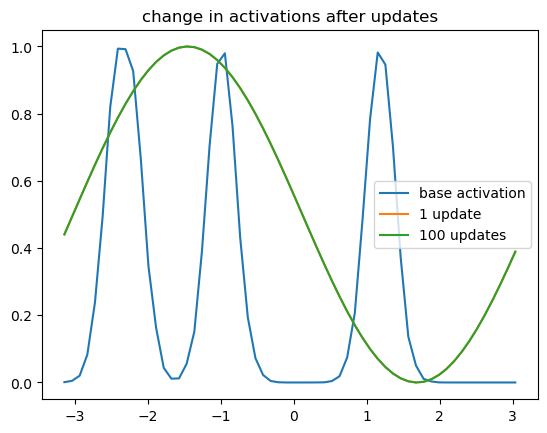

In [89]:
# hier habe ich schon die Matrix W und eine Initialisierung der Neuronen vorgenommen
inst = Instance(p_inst)
agent = inst.agents[0]
# create some base activation
agent.activate_neurons()

# plot base activation
plt.plot(agent.angles,agent.activations)
# agent.visualize_net(mode="curr_state")
# update one time
def update(activ, num, mode=1):
    for i in range(num):
        # test different approaches from above
        match mode:
            case 1:
                new_activations = torch.matmul(agent.weight_matrix,activ)
                activ = new_activations
            case 2:
                new_activations = torch.matmul(agent.weight_matrix,activ)
                activ = new_activations/torch.max(torch.abs(new_activations))
            case 3:
                new_activations = torch.matmul(agent.weight_matrix,activ)
                activ = (1+ new_activations/torch.max(torch.abs(new_activations)))/2
            case 4:
                new_activations = torch.matmul(agent.weight_matrix,activ)
                activ = torch.sigmoid(new_activations/torch.max(torch.abs(new_activations)))
            case 45:
                new_activations = torch.matmul(agent.weight_matrix,activ)
                activ = torch.min(torch.max(new_activations/torch.max(torch.abs(new_activations)),torch.tensor([-1])),torch.tensor([1]))
            case 5:
                new_activations = activ + torch.matmul(agent.weight_matrix,activ)/torch.linalg.norm(torch.abs(new_activations),ord=1)
                activ = torch.min(torch.max(new_activations,torch.tensor([-1])),torch.tensor([1]))
    return activ

mode = 3
agent.activations = update(agent.activations, 1, mode=mode)
plt.plot(agent.angles, agent.activations)
# agent.visualize_net(mode="curr_state")

#update again
num_updates = 99
agent.activations = update(agent.activations, num = num_updates, mode=mode)
# agent.visualize_net(mode="curr_state")

plt.plot(agent.angles, agent.activations)
plt.title("change in activations after updates")
plt.legend(["base activation", "1 update", f"{num_updates+1} updates"])


In [82]:

pref_angle = torch.pi*(1/4)

num_targets = 1
target_angle= torch.pi*(-0/4)
target = torch.tensor([np.exp(1j*target_angle)])
# targets = torch.tensor([np.exp(1j*2*torch.pi*i/num_targets) for i in range(num_targets)])

neuron = Neuron(pref_angle)
neuron.activate(target)
# plt.scatter(targets.numpy().real, targets.numpy().imag)
# plt.xlim([-1.5,1.5])
# plt.ylim([-1.5,1.5])

NameError: name 'Neuron' is not defined

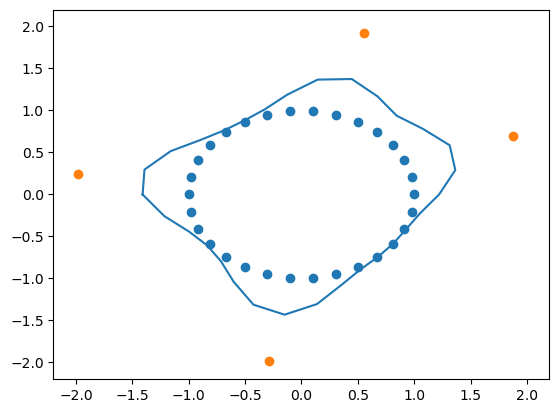

In [ ]:


inst.agents[0].visualizeNet(mode="curr_state")

torch.Size([100])


Text(0.5, 1.0, 'base activation for sigma=0.5')

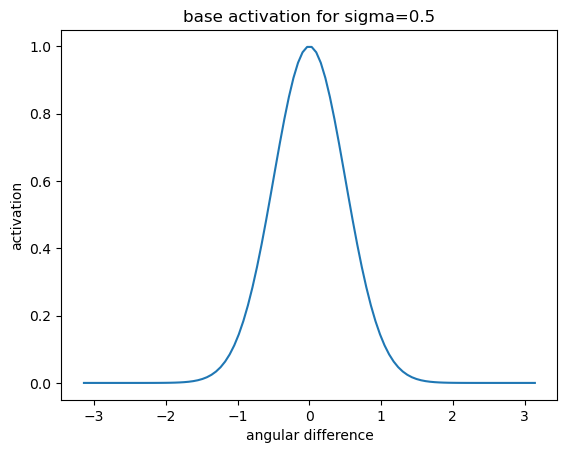

In [680]:
normal_std = 0.5
activation_func = lambda theta: 1/(normal_std*torch.sqrt(torch.Tensor([2*torch.pi])))*torch.exp(-1/2*(theta/normal_std)**2)
max_activation_func = torch.max(activation_func(torch.tensor(np.linspace(0,2*np.pi))))
angles = torch.linspace(start=-torch.pi, end=torch.pi, steps=100)
print(angles.shape)
plt.plot(angles, activation_func(angles)/max_activation_func)
plt.xlabel("angular difference")
plt.ylabel("activation")
plt.title(f"base activation for sigma={normal_std}")

## Kontinuierliches Model
Ich hatte die Idee ein kontinuierliches Modell zu bauen. Dieses soll folgendermaßen funktionieren:
Wir wollen eine Funktion definieren, welche Aktivierungen auf dem Kreis darstellt und sich über die Zeit verändert.

$ A: S^1\times [0,\infty) \rightarrow [0, 1]$

Die Funktion $A(\theta, t)$ soll zur Zeit $t=0$ bestimmt sein. Um die Änderung von $A$ über Zeit zu bestimmen, stellen wir folgende DGL in Anlehnung an die zuvor definierten Interaktionen der Winkel :

$\frac{\partial A(\theta, t)}{\partial t}  = \int_{S^1} \cos(|\theta- \tilde{\theta}|) A(\tilde{\theta}, t) d\tilde{\theta}$

Da ich keine Ahnung habe, wie man Integro-DGL behandelt, werde ich sie zunächst versuchen numerisch zu berechnen. Dabei ist mir aufgefallen, dass die numerische Berechnung im Endeffekt das Gleiche ist wie mein vorheriger Ansatz.

chosen angle: 1.923


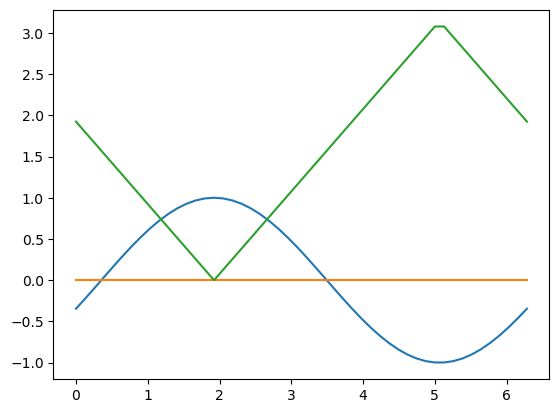

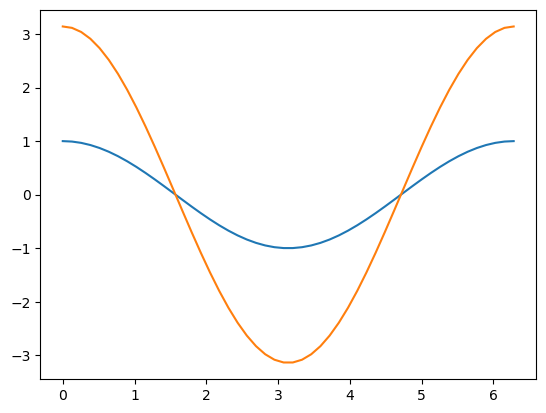

In [87]:
import numpy as np
import torch 

def smallest_angle_to(curr_angle, targets):
    angles = curr_angle - targets
    abs_angle = torch.minimum(torch.absolute(angles), 2*torch.pi - torch.absolute(angles))
    return abs_angle

def smallest_angle_pw(angles1, angles2):
    pw_dif = angles1.unsqueeze(1) - angles2
    abs_angle = torch.minimum(torch.absolute(pw_dif), 2*torch.pi - torch.absolute(pw_dif))
    return abs_angle

# define a basic activation function
A = lambda theta: torch.cos(theta)
# angles between 0 and 2pi
thetas = torch.tensor(np.linspace(0, 2*np.pi))
theta_0 = thetas[15]
print(f"chosen angle: {theta_0:.3f}")
nu = 1

int_func = lambda theta, thetas: torch.cos(torch.pi*(smallest_angle_pw(theta, thetas)/torch.pi)**nu )
res = torch.trapz(int_func(thetas, thetas)*A(thetas),thetas)
plt.plot(thetas, torch.cos(torch.pi*(smallest_angle_to(theta_0, thetas)/torch.pi)**nu ))
plt.plot([thetas[0], thetas[-1]], [0,0])
plt.plot(thetas,smallest_angle_to(theta_0, thetas))


plt.show()
plt.plot(thetas, A(thetas))
plt.plot(thetas, res)
plt.show()

In [ ]:

int_func = lambda theta, thetas: torch.cos(torch.pi*(smallest_angle_pw(theta, thetas)/torch.pi)**nu )
A = lambda theta: theta*(1-theta/(2*torch.pi))

A_t = [A]
for i in range(2):
    A = A_t[i] 
    deriv = lambda theta: torch.trapz(int_func(theta, thetas)*A(thetas))
    dt = 0.01
    A_t.append( lambda theta: A(theta) + dt*deriv(thetas))

plt.plot(thetas,A_t[-1](thetas))



KeyboardInterrupt



In [ ]:
class AgentNet(nn.Module):
    ''' Neural Network for the decision making of the agent.'''

    # Idea: Each neuron gets a certain range of angles in which it gets activated whenever there is at least one target in this range
    # At first I will try the following simple idea:

    def __init__(self, params:Param_Agent) -> None:
        super().__init__()
        self.input_size = params.n_neurons 
        self.layer1 = nn.Linear(self.input_size, self.input_size)
        self.activation = nn.Tanh()

    def forward(self, x):
        '''x will be the last inputs, multiplied by the target acitvations'''
        x = self.layer1(x)
        x = self.activation(x)
        return x
    

                  
class Neuron():
    def __init__(self, pref_angle, activation_width) -> None:
        self.pref_angle = pref_angle
        
        normal_std = activation_width
        self.activation_func = lambda theta: 1/(normal_std*np.sqrt(2*np.pi))*torch.exp(-1/2*(theta/normal_std)**2)
        self.max_base_activation = torch.max(self.activation_func(torch.tensor(np.linspace(0, 2*np.pi))))
        self.activation = 0

    def activate(self, targets: torch.Tensor):
        # find the closest angles between neuron preferred angle and targets
        self.activation =torch.max(self.activation_func(self.smallest_angle_to(targets)))/(0.5*self.max_base_activation)
        return self.activation

    def smallest_angle_to(self, targets):
        angles = self.pref_angle - torch.angle(targets)
        abs_angle = torch.minimum(torch.absolute(angles), 2*torch.pi - torch.absolute(angles))
        return abs_angle

    